In [16]:
import pandas as pd
import numpy as np
pd.set_option('display.max_row', 150)
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
result = pd.read_csv("./eval_result/predict_result.csv")
result = result[result["model"]!="svm"]
result = result[result["model"]!="et"]

result2 = pd.read_csv("./eval_result/predict_result2.csv")
result2 = result2[result2["model"]!="svm"]
result2 = result2[result2["model"]!="et"]

result3 = pd.read_csv("./eval_result/predict_result3.csv")
result3 = result3[result3["model"]!="svm"]
result3 = result3[result3["model"]!="et"]

In [18]:
result2 = pd.concat([result2, result3]).reset_index(drop = True)

In [19]:
result3["data"].unique()

array(['GC', 'BZ', 'CL', 'VX', 'MGC', 'UB', 'MME'], dtype=object)

### 3.2.1.1. Model Evaluation (Q1)

In [20]:
def model_eval(path, coin_name, model_name, time):
    
    """
    path : risk result path
    coin_name : name of coin 
    model_name : name of model 
    time : e.g., 4h, 8h, 12h, 1d
    """
    

    time_norm = pd.read_csv(f"./eval_result/{path}.csv")

    time_norm = time_norm[time_norm["data"] == coin_name]
    time_norm = time_norm[time_norm["model"] ==  model_name]


    mask_targer_label = time_norm["label"].isin(["Target_Label"])
    time_norm_target = time_norm[mask_targer_label]
    time_norm = time_norm[~mask_targer_label]


    post_label = [ 'Target_2.0post_Label',
           'Target_2.2post_Label', 'Target_2.4post_Label',
           'Target_2.6post_Label', 'Target_2.8post_Label',
           'Target_3.0post_Label', 'Target_3.2post_Label',
           'Target_3.4post_Label', 'Target_3.6post_Label',
           'Target_3.8post_Label', 'Target_4.0post_Label']

    mask2 = time_norm["label"].isin(post_label)

    post_data = time_norm[mask2]
    new_data = time_norm[~mask2]

    time_norm_target.iloc[:, 4:9] = time_norm_target.iloc[:, 4:9].astype(float).copy() 
    new_data.iloc[:, 4:9] = new_data.iloc[:, 4:9].astype(float).round(4).copy()

    time_norm_target = time_norm_target.iloc[:, :9].reset_index().iloc[:, 1:]
    new_data = new_data.iloc[:, :9].reset_index().iloc[:, 1:]
    new_data = new_data[new_data["time"] == time].reset_index().iloc[:, 1:]
    new_data = new_data.sort_values("label").reset_index().iloc[:, 1:]

    time_norm_target_value = pd.DataFrame([time_norm_target[time_norm_target["time"] == time].iloc[:, 4:].reset_index().iloc[:, 1:].values[0] for i in range(new_data[new_data["time"] == time].shape[0])])
    time_norm_target_value.columns = ["acc","auc", "mcc", "precision", "recall"]
    
    percent = (((new_data.iloc[:, 4:] / time_norm_target_value)-1 ) * 100).round(4)
    percent.columns = ["acc_p","auc_p", "mcc_p", "precision_p", "recall_p"]
    
    time_norm_target_value = pd.concat([new_data.iloc[:, :4], time_norm_target_value], axis = 1)
    
    output =  pd.concat([time_norm_target_value,new_data ]).reset_index().iloc[:, 1:]
    output = output.drop(["data","time","model"], axis = 1)
    
    melt_data = time_norm_target_value.iloc[0:1, :][["label","acc","auc"]].copy()
    melt_data = melt_data.melt("label")
    melt_data["label"] = "Target_Label"
    
    new_data = new_data[["label","acc","auc"]]
    new_data = new_data.melt(["label"])
    
    
    
    return new_data, melt_data #pd.concat([new_data, melt_data]).reset_index().iloc[:, 1:]

In [21]:
cat_4h , melt_4h     =model_eval("predict_result", "BTC", "cat", "4h")

In [22]:
melt_4h # ST_\delta - NT

,label,variable,value
0,Target_Label,acc,0.546713
1,Target_Label,auc,0.546742


## Q1 plot

In [23]:
def all_models(predict_result, coin):
    cat_4h , melt_4h     =model_eval(predict_result, coin, "cat", "4h")
    rf_4h , melt_rf_4h   =model_eval(predict_result, coin, "rf", "4h")
    mlp_4h , melt_mlp_4h =model_eval(predict_result, coin, "mlp", "4h")
    knn_4h , melt_knn_4h =model_eval(predict_result, coin, "knn", "4h")
    et_4h , melt_et_4h   =model_eval(predict_result, coin, "et", "4h")
    xg_4h , melt_xg_4h   =model_eval(predict_result, coin, "xg", "4h")


    auc_cat_4h_data = cat_4h[cat_4h["variable"] == "auc"]["value"].values - melt_4h[melt_4h["variable"] == "auc"]["value"].values
    auc_rf_4h_data = rf_4h[rf_4h["variable"] == "auc"]["value"].values - melt_rf_4h[melt_rf_4h["variable"] == "auc"]["value"].values
    auc_mlp_4h_data = mlp_4h[mlp_4h["variable"] == "auc"]["value"].values - melt_mlp_4h[melt_mlp_4h["variable"] == "auc"]["value"].values
    auc_knn_4h_data = knn_4h[knn_4h["variable"] == "auc"]["value"].values - melt_knn_4h[melt_knn_4h["variable"] == "auc"]["value"].values
    auc_et_4h_data = et_4h[et_4h["variable"] == "auc"]["value"].values - melt_et_4h[melt_et_4h["variable"] == "auc"]["value"].values
    auc_xg_4h_data = xg_4h[xg_4h["variable"] == "auc"]["value"].values - melt_xg_4h[melt_xg_4h["variable"] == "auc"]["value"].values

    auc_data_4h  = pd.DataFrame([auc_cat_4h_data,  auc_rf_4h_data,  auc_mlp_4h_data, auc_knn_4h_data, auc_et_4h_data, auc_xg_4h_data]).melt().iloc[:, 1]
    
    auc_data =  pd.concat([auc_data_4h], axis = 1)
    auc_data.columns = ["4h"]
    auc_data["delta"] = ['d2.0','d2.2', 'd2.4', 'd2.6', 'd2.8', 'd3.0', 'd3.2', 'd3.4', 'd3.6', 'd3.8', 'd4.0'] * 6
    
    auc_data = auc_data.melt("delta")

    return auc_data

In [24]:
btc_auc = all_models("predict_result","BTC")
eth_auc = all_models("predict_result","ETH")
doge_auc= all_models("predict_result","DOGE")
sol_auc = all_models("predict_result","SOL")
bnb_auc = all_models("predict_result","BNB")
ada_auc = all_models("predict_result","ADA")
xrp_auc = all_models("predict_result","XRP")

total_auc = pd.concat([btc_auc, eth_auc, doge_auc, sol_auc, bnb_auc, ada_auc, xrp_auc]).reset_index().iloc[:,1:]

In [25]:
YM_auc = all_models("predict_result2","YM")
NQ_auc = all_models("predict_result2","NQ")
ES_auc = all_models("predict_result2","ES")
PA_auc = all_models("predict_result2","PA")
EW_auc = all_models("predict_result2","EW")
UB_auc = all_models("predict_result3","UB")
CL_auc = all_models("predict_result3","CL")
VX_auc = all_models("predict_result3","VX")
RTY_auc = all_models("predict_result2","RTY")

total_auc2 = pd.concat([YM_auc, NQ_auc, ES_auc, PA_auc, EW_auc, UB_auc, CL_auc, VX_auc, RTY_auc]).reset_index().iloc[:,1:]

In [11]:
total_auc

,delta,variable,value
0,d2.0,4h,0.018358
1,d2.2,4h,0.017015
2,d2.4,4h,-0.003091
3,d2.6,4h,0.017932
4,d2.8,4h,-0.013929
...,...,...,...
457,d3.2,4h,-0.009850
458,d3.4,4h,-0.004658
459,d3.6,4h,0.005118
460,d3.8,4h,-0.005509


In [26]:
### Label이 몇개나 변한지..?실제로?
target_label_list = ['Target_Label', 'Target_2.0_Label', 'Target_2.2_Label',
       'Target_2.4_Label', 'Target_2.6_Label', 'Target_2.8_Label',
       'Target_3.0_Label', 'Target_3.2_Label', 'Target_3.4_Label',
       'Target_3.6_Label', 'Target_3.8_Label', 'Target_4.0_Label']


btc_4h   = pd.read_csv("../prepro/BTC_4h.csv")[target_label_list]
eth_4h   = pd.read_csv("../prepro/ETH_4h.csv")[target_label_list]
doge_4h   = pd.read_csv("../prepro/DOGE_4h.csv")[target_label_list]
sol_4h   = pd.read_csv("../prepro/SOL_4h.csv")[target_label_list]
bnb_4h   = pd.read_csv("../prepro/BNB_4h.csv")[target_label_list]
ada_4h   = pd.read_csv("../prepro/ADA_4h.csv")[target_label_list]
xrp_4h  = pd.read_csv("../prepro/XRP_4h.csv")[target_label_list]

btc_label_change_4h  =(  btc_4h.sum()[1:] - btc_4h.sum()[0]   ).abs()
eth_label_change_4h  =(  eth_4h.sum()[1:] - eth_4h.sum()[0]   ).abs()
sol_label_change_4h  =(  sol_4h.sum()[1:] - sol_4h.sum()[0] ).abs()
bnb_label_change_4h  =(  bnb_4h.sum()[1:] - bnb_4h.sum()[0] ).abs()
ada_label_change_4h  =(  ada_4h.sum()[1:] - ada_4h.sum()[0] ).abs()
xrp_label_change_4h  =(  xrp_4h.sum()[1:] - xrp_4h.sum()[0] ).abs()
dog_label_change_4h = ( doge_4h.sum()[1:] - doge_4h.sum()[0] ).abs()


all_change_4h = pd.concat([
pd.DataFrame(btc_label_change_4h ).T,
pd.DataFrame(eth_label_change_4h ).T,
pd.DataFrame(sol_label_change_4h ).T,
pd.DataFrame(bnb_label_change_4h ).T,
pd.DataFrame(ada_label_change_4h ).T,
pd.DataFrame(xrp_label_change_4h ).T,
pd.DataFrame(dog_label_change_4h ).T,

])

all_change_4h.columns = ['d0.40','d0.44', 'd0.48', 'd0.52', 'd0.56', 'd0.60', 'd0.64', 'd0.68', 'd0.72', 'd0.76', 'd0.80']
all_change_4h = all_change_4h.melt()

In [27]:
### Label이 몇개나 변한지..?실제로?
target_label_list = ['Target_Label', 'Target_2.0_Label', 'Target_2.2_Label',
       'Target_2.4_Label', 'Target_2.6_Label', 'Target_2.8_Label',
       'Target_3.0_Label', 'Target_3.2_Label', 'Target_3.4_Label',
       'Target_3.6_Label', 'Target_3.8_Label', 'Target_4.0_Label']


btc_4h   = pd.read_csv("../prepro/YM_4h.csv")[target_label_list]
eth_4h   = pd.read_csv("../prepro/NQ_4h.csv")[target_label_list]
doge_4h   = pd.read_csv("../prepro/ES_4h.csv")[target_label_list]
sol_4h   = pd.read_csv("../prepro/PA_4h.csv")[target_label_list]
bnb_4h   = pd.read_csv("../prepro/EW_4h.csv")[target_label_list]
ada_4h   = pd.read_csv("../prepro/UB_4h.csv")[target_label_list]
xrp_4h  = pd.read_csv("../prepro/CL_4h.csv")[target_label_list]
vx_4h  = pd.read_csv("../prepro/VX_4h.csv")[target_label_list]
rty_4h  = pd.read_csv("../prepro/RTY_4h.csv")[target_label_list]

btc_label_change_4h  =(  btc_4h.sum()[1:] - btc_4h.sum()[0]   ).abs()
eth_label_change_4h  =(  eth_4h.sum()[1:] - eth_4h.sum()[0]   ).abs()
sol_label_change_4h  =(  sol_4h.sum()[1:] - sol_4h.sum()[0] ).abs()
bnb_label_change_4h  =(  bnb_4h.sum()[1:] - bnb_4h.sum()[0] ).abs()
ada_label_change_4h  =(  ada_4h.sum()[1:] - ada_4h.sum()[0] ).abs()
xrp_label_change_4h  =(  xrp_4h.sum()[1:] - xrp_4h.sum()[0] ).abs()
dog_label_change_4h = ( doge_4h.sum()[1:] - doge_4h.sum()[0] ).abs()
vx_label_change_4h  =(  vx_4h.sum()[1:] - vx_4h.sum()[0] ).abs()
rty_label_change_4h = ( rty_4h.sum()[1:] - rty_4h.sum()[0] ).abs()


all_stock_change_4h = pd.concat([
pd.DataFrame(btc_label_change_4h ).T,
pd.DataFrame(eth_label_change_4h ).T,
pd.DataFrame(sol_label_change_4h ).T,
pd.DataFrame(bnb_label_change_4h ).T,
pd.DataFrame(ada_label_change_4h ).T,
pd.DataFrame(xrp_label_change_4h ).T,
pd.DataFrame(dog_label_change_4h ).T,
pd.DataFrame(vx_label_change_4h ).T,
pd.DataFrame(rty_label_change_4h ).T,
])

all_stock_change_4h.columns = ['d0.40','d0.44', 'd0.48', 'd0.52', 'd0.56', 'd0.60', 'd0.64', 'd0.68', 'd0.72', 'd0.76', 'd0.80']
all_stock_change_4h = all_stock_change_4h.melt()

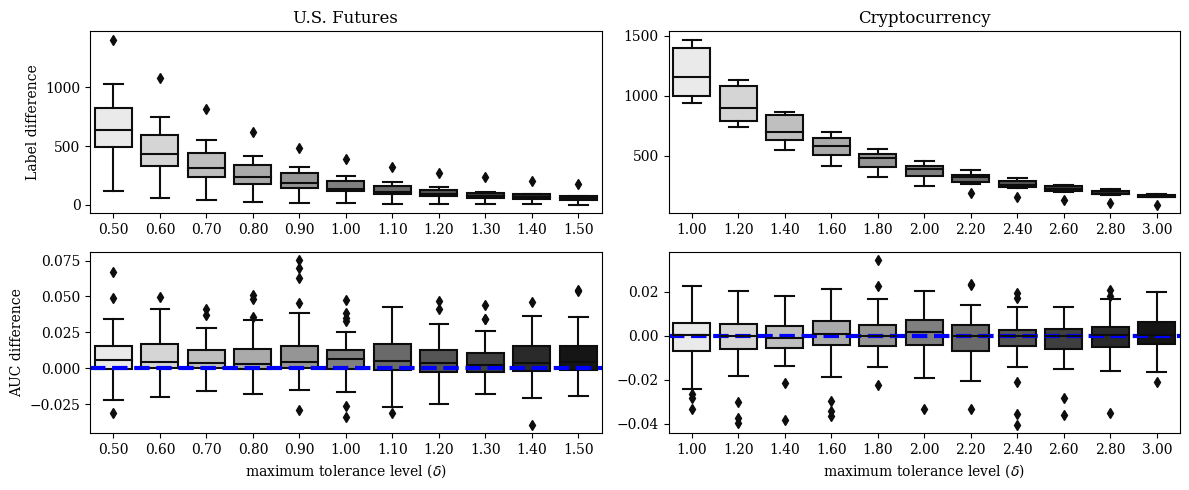

In [47]:
sns.set_style({"style":"white",'font.family':'serif', 'font.serif':'Times New Roman', "font_scale" : 1.7})
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
plt.rcParams["font.family"] = "Times New Roman"


g = sns.boxplot(x = "delta", y="value", data = total_auc2[total_auc2["variable"] == "4h"], ax = axes[1, 0], palette = "gist_gray_r", showfliers = True)
g.axhline(0.0, linestyle = "--", linewidth=3, color = "b")
g.set_title("")
g.legend([],[], frameon=False)
g.set_ylabel("AUC difference")
g.set_xlabel("maximum tolerance level ($\delta$)")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'])



g = sns.boxplot(x = "variable", y="value", data = all_stock_change_4h, ax = axes[0, 0], palette = "gist_gray_r", showfliers = True)
#g.axhline(0.0, linestyle = "--", linewidth=3, color = "b")
#g.axhline(melt_4h.iloc[1, 2], linestyle = ":", linewidth=3, color = "orange")
g.legend([],[], frameon=False)
g.set_title("U.S. Futures")
g.set_ylabel("Label difference")
g.set_xlabel("")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'])




g = sns.boxplot(x = "delta", y="value", data = total_auc[total_auc["variable"] == "4h"], ax = axes[1, 1], palette = "gist_gray_r", showfliers = True)
g.axhline(0.0, linestyle = "--", linewidth=3, color = "b")
#g.axhline(melt_4h.iloc[1, 2], linestyle = ":", linewidth=3, color = "orange")
g.legend([],[], frameon=False)
g.set_ylabel("")
g.set_xlabel("maximum tolerance level ($\delta$)")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'])

g = sns.boxplot(x = "variable", y="value", data = all_change_4h, ax = axes[0, 1], palette = "gist_gray_r", showfliers = True)
#g.axhline(melt_4h.iloc[1, 2], linestyle = ":", linewidth=3, color = "orange")
g.legend([],[], frameon=False)
g.set_title("Cryptocurrency")
g.set_ylabel("")
g.set_xlabel("")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'])


plt.tight_layout()
plt.savefig("Result_of_model_evaluation.pdf")
plt.savefig("Result_of_model_evaluation.png")